In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

MODELS_DIR = os.path.join(os.getcwd(), '..', 'models')

# Single run

- Is a combination of parameters stable across outer folds?
- Is a combination of parameters stable across inner folds?
- How do performances change across combinations?

- What can the metrics other than f1 tell me?

# Compare pipelines

- How do outer performances compare across the different pipelines?
- Which pipeline gives the most consistent results?

- Which hyperparameters perform best?

In [2]:
def load_avg_std_folds(cv_results, metric):
    scores = dict()
    for outer_fold in cv_results:
        scores[outer_fold] = cv_results[outer_fold][f'mean_test_{metric}']
    avg_scores = np.mean(list(scores.values()), axis=0)
    std_scores = np.std(list(scores.values()), axis=0)

    return avg_scores, std_scores

def load_best(cv_results, metric):
    mean = []
    std = []
    for fold in cv_results.keys():
        i = cv_results[fold]['best_index']
        mean.append(cv_results[fold][f'mean_test_{metric}'][i])
        std.append(cv_results[fold][f'std_test_{metric}'][i])

    return mean, std

def load_best_time(cv_results):
    mean_fit = []
    std_fit = []
    mean_score = []
    std_score = []
    for fold in cv_results.keys():
        i = cv_results[fold]['best_index']
        mean_fit.append(cv_results[fold]['mean_fit_time'][i])
        std_fit.append(cv_results[fold]['std_fit_time'][i])
        mean_score.append(cv_results[fold]['mean_score_time'][i])
        std_score.append(cv_results[fold]['std_score_time'][i])

    return mean_fit, std_fit, mean_score, std_score

def load_params(cv_results):
    params = []
    for fold in cv_results.keys():
        i = cv_results[fold]['best_index']
        params.append(cv_results[fold]['params'][i])

    return params

In [3]:
metrics = [ "accuracy", "precision", "recall", "f1", "roc_auc" ]
refit = 'f1'
models = ['20240124170849', '20240124171002', '20240124181627', '20240124183417', '20240124191638', '20240124194227']
pipelines = ['T5_None', 'XL_None', 'T5_ADASYN', 'XL_ADASYN', 'T5_SMOTE', 'XL_SMOTE']

# Define a dict for the colors, using qualitative paired map
colors = plt.cm.Paired.colors
colors_dict = dict()
colors_dict['T5_None'] = colors[0]
colors_dict['XL_None'] = colors[1]
colors_dict['T5_ADASYN'] = colors[2]
colors_dict['XL_ADASYN'] = colors[3]
colors_dict['T5_SMOTE'] = colors[4]
colors_dict['XL_SMOTE'] = colors[5]
colors_dict['Boeckaerts'] = colors[6]
colors_dict['T5_Gonzales'] = colors[8]
colors_dict['XL_Gonzales'] = colors[9]

# Sort both lists based on pipelines
models, pipelines = zip(*sorted(zip(models, pipelines), key=lambda x: x[1]))

outer_folds = dict()
inner_folds = dict()
outer_predictions = dict()

for (mdl, pipe) in zip(models, pipelines):
    MODEL_DIR = os.path.join(MODELS_DIR, mdl)
    # Outer folds scores
    best_dict = joblib.load(os.path.join(MODEL_DIR, 'best_dict.pkl'))
    out_preds = joblib.load(os.path.join(MODEL_DIR, 'outer_predictions.pkl'))
    outer_folds[pipe] = dict()
    outer_folds[pipe]["outer_scores"] = best_dict["outer_scores"]
    outer_folds[pipe]["best_outer_score"] = best_dict["best_outer_score"]
    outer_folds[pipe]["mean_outer_score"] = best_dict["mean_outer_score"]
    outer_folds[pipe]["std_outer_score"] = np.std(best_dict["outer_scores"])
    outer_folds[pipe]["y_true"] = []
    outer_folds[pipe]["y_proba"] = []
    for fold in out_preds.keys():
        outer_folds[pipe]["y_true"].append(out_preds[fold]["y_test"])
        outer_folds[pipe]["y_proba"].append(out_preds[fold]["y_proba"][:, 1])
    outer_folds[pipe]["y_true_all"] = np.concatenate(outer_folds[pipe]["y_true"])
    outer_folds[pipe]["y_proba_all"] = np.concatenate(outer_folds[pipe]["y_proba"])
    cv_results = joblib.load(os.path.join(MODEL_DIR, 'cv_results.pkl'))
    # Store indexes of the best performing hyperparameter of each outer fold in cv_results
    for fold in cv_results.keys():
        cv_results[fold]["best_index"] = best_dict[fold]["best_index"]
    outer_folds[pipe]["params"] = load_params(cv_results)

    # Load scores and times of the best performing hyperparameters on the inner folds, across outer folds
    inner_folds[pipe] = dict()

    for metric in metrics:
        avg_scores, std_scores = load_best(cv_results, metric)
        inner_folds[pipe][metric] = dict()
        inner_folds[pipe][metric]["mean"] = avg_scores
        inner_folds[pipe][metric]["std"] = std_scores

    inner_folds[pipe]["score_time"] = dict()
    inner_folds[pipe]["fit_time"] = dict()
    mean_fit, std_fit, mean_score, std_score = load_best_time(cv_results)
    inner_folds[pipe]["score_time"]["mean"] = mean_score
    inner_folds[pipe]["score_time"]["std"] = std_score
    inner_folds[pipe]["fit_time"]["mean"] = mean_fit
    inner_folds[pipe]["fit_time"]["std"] = std_fit

In [4]:
print(outer_folds["T5_ADASYN"]["params"])

[{'classifier__criterion': 'gini', 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}, {'classifier__criterion': 'gini', 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}, {'classifier__criterion': 'gini', 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 50}, {'classifier__criterion': 'gini', 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}, {'classifier__criterion': 'gini', 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 150}]


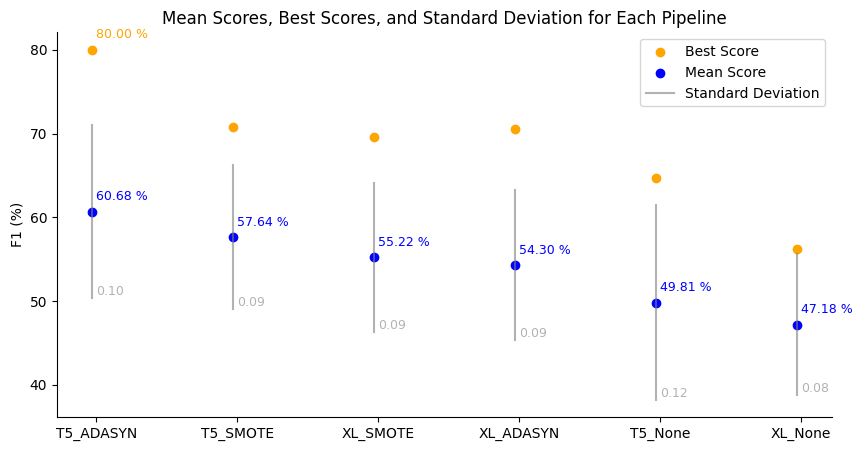

In [5]:
# Prepare data
pipes = list(outer_folds.keys())
mean_scores = [outer_folds[pipe]["mean_outer_score"] * 100 for pipe in pipes]
best_scores = [outer_folds[pipe]["best_outer_score"] * 100 for pipe in pipes]
std_scores = [outer_folds[pipe]["std_outer_score"] * 100 for pipe in pipes]

# Sort pipes based on mean_scores in descending order
pipes, mean_scores, best_scores, std_scores = zip(*sorted(zip(pipes, mean_scores, best_scores, std_scores), key=lambda x: x[1], reverse=True))

# Set colors
mean_color = 'blue'
best_color = 'orange'
std_color = 'gray'
std_alpha = 0.6

# Define the offset for moving the dots and bars to the left
offset = 0.03

# Plot the scatter chart
plt.figure(figsize=(10, 5))
plt.scatter([i - offset for i in range(len(pipes))], best_scores, color=best_color, label='Best Score')
plt.scatter([i - offset for i in range(len(pipes))], mean_scores, color=mean_color, label='Mean Score')

# Plot std and text
for i, pipe in enumerate(pipes):
    plt.plot([i - offset, i - offset], [mean_scores[i] - std_scores[i], mean_scores[i] + std_scores[i]], color=std_color, alpha=std_alpha)
    if pipe == 'T5_ADASYN':
        plt.text(i, best_scores[i] + 1, f'{best_scores[i]:.2f} %', ha='left', va='bottom', fontsize=9, color=best_color)
    plt.text(i, mean_scores[i] + 1, f'{mean_scores[i]:.2f} %', ha='left', va='bottom', fontsize=9, color=mean_color)
    plt.text(i, mean_scores[i] + -std_scores[i], f'{std_scores[i]/100:.2f}', ha='left', va='bottom', fontsize=9, color=std_color, alpha=std_alpha)

# Set labels and title
plt.ylabel(refit.upper() + ' (%)')
plt.title('Mean Scores, Best Scores, and Standard Deviation for Each Pipeline')

# Set xticks as pipes
plt.xticks(range(len(pipes)), pipes)

# Remove upper and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show legend
plt.legend(['Best Score', 'Mean Score', 'Standard Deviation'])

# save as png for report
PLOTS_DIR = os.path.join(os.getcwd(), '..', 'latex_pictures')
plt.savefig(os.path.join(PLOTS_DIR, 'F1_50.png'), bbox_inches='tight')

# Show the plot
plt.show()


In [6]:
# Print the best hyperparameters for each pipeline
for pipe in pipelines:
    print(pipe)
    for param in outer_folds[pipe]['params'][0].keys():
        print(f'\t{param}: {outer_folds[pipe]["params"][0][param]}')

T5_ADASYN
	classifier__criterion: gini
	classifier__max_features: log2
	classifier__min_samples_leaf: 3
	classifier__min_samples_split: 2
	classifier__n_estimators: 100
T5_None
	classifier__criterion: gini
	classifier__max_features: sqrt
	classifier__min_samples_leaf: 2
	classifier__min_samples_split: 2
	classifier__n_estimators: 100
T5_SMOTE
	classifier__criterion: gini
	classifier__max_features: sqrt
	classifier__min_samples_leaf: 4
	classifier__min_samples_split: 2
	classifier__n_estimators: 200
XL_ADASYN
	classifier__criterion: gini
	classifier__max_features: sqrt
	classifier__min_samples_leaf: 2
	classifier__min_samples_split: 4
	classifier__n_estimators: 200
XL_None
	classifier__criterion: gini
	classifier__max_features: sqrt
	classifier__min_samples_leaf: 3
	classifier__min_samples_split: 3
	classifier__n_estimators: 200
XL_SMOTE
	classifier__criterion: gini
	classifier__max_features: log2
	classifier__min_samples_leaf: 4
	classifier__min_samples_split: 2
	classifier__n_estimato

(Might put this in the end of "Comparing pipelines")

Lastly, it might be useful to compare training and testing times for each pipeline. The Random Forest algorithm is quite efficient in determining each tree's structure, and requires noticeably less time and resources than other approaches like neural networks and transformers. However, when scaling to larger input dataset, maybe including a broader range of organisms, it is important to be able to estimate the time required to perform the duty. 

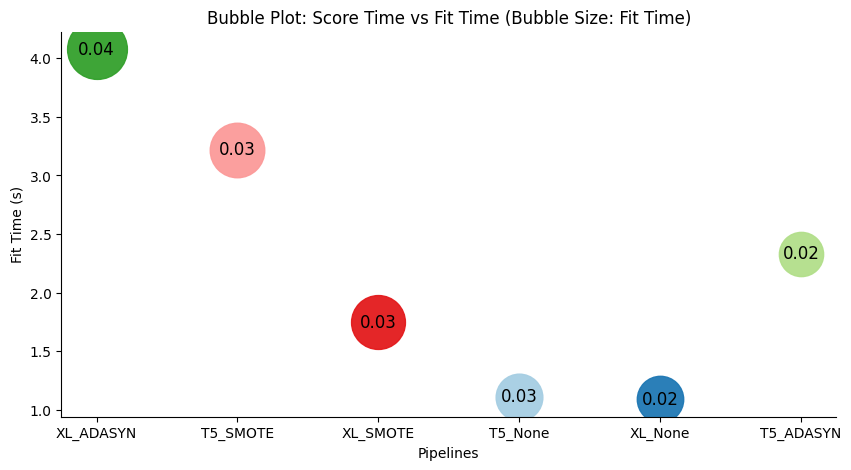

In [7]:
# Prepare data
score_time = [np.mean(inner_folds[pipe]['score_time']['mean']) for pipe in pipelines]
fit_time = [np.mean(inner_folds[pipe]['fit_time']['mean']) for pipe in pipelines]

# Sort pipelines based on score time in descending order
pipes, score_time, fit_time = zip(*sorted(zip(pipelines, score_time, fit_time), key=lambda x: x[1], reverse=True))

# Set bubble size
bubble_size = [f * 45000 for f in score_time]

# Plot the bubble plot
plt.figure(figsize=(10, 5))
for i in range(len(pipes)):
    plt.scatter(pipes[i], fit_time[i], s=bubble_size[i], alpha=0.95, color=colors_dict[pipes[i]])
    plt.annotate(f'{score_time[i]:.2f}', (pipes[i], fit_time[i]), fontsize=12, ha='center', va='center')

# Set labels and title
plt.xlabel('Pipelines')
plt.ylabel('Fit Time (s)')
plt.title('Bubble Plot: Score Time vs Fit Time (Bubble Size: Fit Time)')

# Remove upper and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save plot as png for report
plt.savefig(os.path.join(PLOTS_DIR, 'score_time.png'), bbox_inches='tight')

# Show the plot
plt.show()


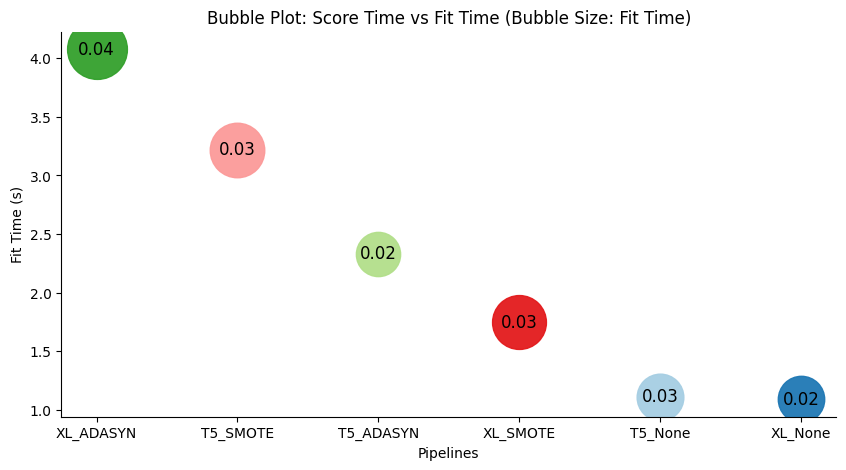

In [8]:
# Prepare data
score_time = [np.mean(inner_folds[pipe]['score_time']['mean']) for pipe in pipelines]
fit_time = [np.mean(inner_folds[pipe]['fit_time']['mean']) for pipe in pipelines]

# Sort pipelines based on score time in descending order
pipes, score_time, fit_time = zip(*sorted(zip(pipelines, score_time, fit_time), key=lambda x: x[2], reverse=True))

# Set bubble size
bubble_size = [f * 45000 for f in score_time]

# Plot the bubble plot
plt.figure(figsize=(10, 5))
for i in range(len(pipes)):
    plt.scatter(pipes[i], fit_time[i], s=bubble_size[i], alpha=0.95, color=colors_dict[pipes[i]])
    plt.annotate(f'{score_time[i]:.2f}', (pipes[i], fit_time[i]), fontsize=12, ha='center', va='center')

# Set labels and title
plt.xlabel('Pipelines')
plt.ylabel('Fit Time (s)')
plt.title('Bubble Plot: Score Time vs Fit Time (Bubble Size: Fit Time)')

# Remove upper and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save plot as png for report
plt.savefig(os.path.join(PLOTS_DIR, 'fit_time.png'), bbox_inches='tight')

# Show the plot
plt.show()


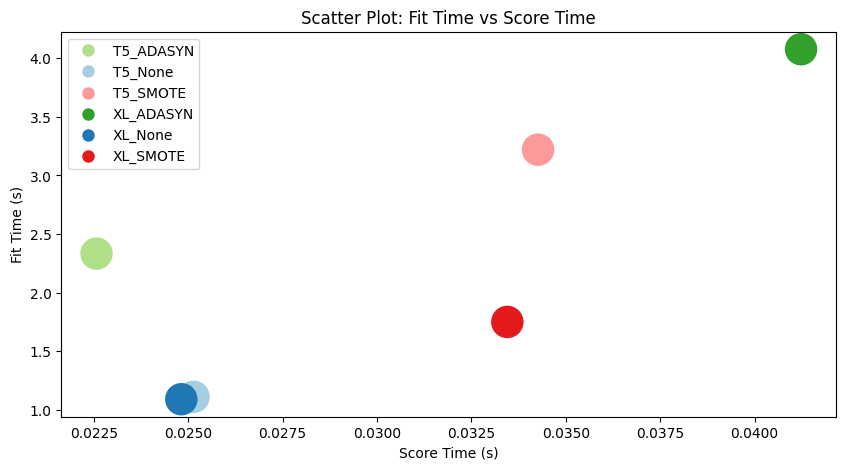

In [9]:
# Prepare data
score_time = [np.mean(inner_folds[pipe]['score_time']['mean']) for pipe in pipelines]
fit_time = [np.mean(inner_folds[pipe]['fit_time']['mean']) for pipe in pipelines]

# Plot the scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(score_time, fit_time, s=500, c=[colors_dict[pipe] for pipe in pipelines])

# Set labels and title
plt.xlabel('Score Time (s)')
plt.ylabel('Fit Time (s)')
plt.title('Scatter Plot: Fit Time vs Score Time')

# Create custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=pipelines[i], markerfacecolor=colors_dict[pipelines[i]], markersize=10) for i in range(len(pipelines))]
plt.legend(handles=legend_elements)
plt.savefig(os.path.join(PLOTS_DIR, 'fit_score_time.png'), bbox_inches='tight')

# Show the plot
plt.show()


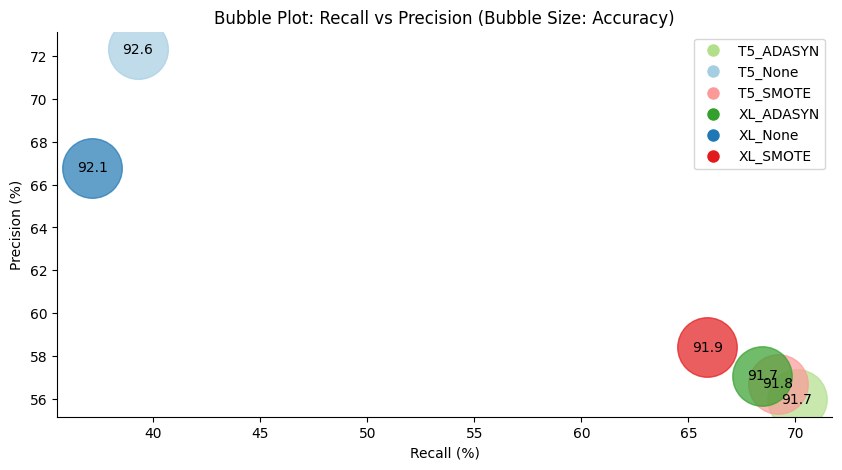

T5_ADASYN
	Precision: 0.56 +/- 0.07
	Recall: 0.70 +/- 0.07
T5_None
	Precision: 0.72 +/- 0.13
	Recall: 0.39 +/- 0.07
T5_SMOTE
	Precision: 0.57 +/- 0.08
	Recall: 0.69 +/- 0.10
XL_ADASYN
	Precision: 0.57 +/- 0.09
	Recall: 0.68 +/- 0.09
XL_None
	Precision: 0.67 +/- 0.11
	Recall: 0.37 +/- 0.06
XL_SMOTE
	Precision: 0.58 +/- 0.09
	Recall: 0.66 +/- 0.10


In [10]:
# Prepare data
precision = [np.mean(inner_folds[pipe]['precision']['mean']) for pipe in pipelines]
accuracy = [np.mean(inner_folds[pipe]['accuracy']['mean']) for pipe in pipelines]
recall = [np.mean(inner_folds[pipe]['recall']['mean']) for pipe in pipelines]

# Set bubble size
bubble_size = [a * 2000 for a in accuracy]

# Plot the bubble plot
plt.figure(figsize=(10, 5))
for i in range(len(pipelines)):
    pipe = pipelines[i]
    plt.scatter(recall[i] * 100, precision[i] * 100, s=bubble_size[i], alpha=0.7, color=colors_dict[pipe])
    plt.annotate(f'{accuracy[i] * 100:.1f}', (recall[i] * 100, precision[i] * 100), fontsize=10, ha='center', va='center', xytext=(0,0), textcoords='offset points') 

# Set labels and title
plt.xlabel('Recall (%)')
plt.ylabel('Precision (%)')
plt.title('Bubble Plot: Recall vs Precision (Bubble Size: Accuracy)')

# Create custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=pipelines[i], markerfacecolor=colors_dict[pipelines[i]], markersize=10) for i in range(len(pipelines))]
plt.legend(handles=legend_elements)

# Remove upper and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save plot as png for report
plt.savefig(os.path.join(PLOTS_DIR, 'bubble_recall.png'), bbox_inches='tight')

# Show the plot
plt.show()

# print precisions and recalls
for pipe in pipelines:
    print(pipe)
    print(f'\tPrecision: {np.mean(inner_folds[pipe]["precision"]["mean"]):.2f} +/- {np.mean(inner_folds[pipe]["precision"]["std"]):.2f}')
    print(f'\tRecall: {np.mean(inner_folds[pipe]["recall"]["mean"]):.2f} +/- {np.mean(inner_folds[pipe]["recall"]["std"]):.2f}')


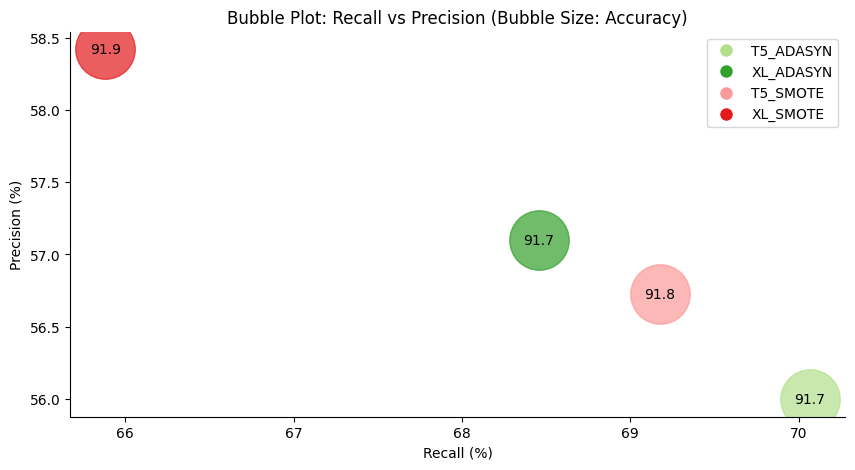

In [11]:
# Prepare data
pipelines_sub = ['T5_ADASYN', 'XL_ADASYN', 'T5_SMOTE', 'XL_SMOTE']
precision = [np.mean(inner_folds[pipe]['precision']['mean']) for pipe in pipelines_sub]
accuracy = [np.mean(inner_folds[pipe]['accuracy']['mean']) for pipe in pipelines_sub]
recall = [np.mean(inner_folds[pipe]['recall']['mean']) for pipe in pipelines_sub]

# Set bubble size
bubble_size = [a * 2000 for a in accuracy]

# Plot the bubble plot
plt.figure(figsize=(10, 5))
for i in range(len(pipelines_sub)):
    pipe = pipelines_sub[i]
    plt.scatter(recall[i] * 100, precision[i] * 100, s=bubble_size[i], alpha=0.7, color=colors_dict[pipe])
    plt.annotate(f'{accuracy[i] * 100:.1f}', (recall[i] * 100, precision[i] * 100), fontsize=10, ha='center', va='center', xytext=(0,0), textcoords='offset points') 

# Set labels and title
plt.xlabel('Recall (%)')
plt.ylabel('Precision (%)')
plt.title('Bubble Plot: Recall vs Precision (Bubble Size: Accuracy)')

# Create custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=pipelines_sub[i], markerfacecolor=colors_dict[pipelines_sub[i]], markersize=10) for i in range(len(pipelines_sub))]
plt.legend(handles=legend_elements)

# Remove upper and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save plot as png for report
plt.savefig(os.path.join(PLOTS_DIR, 'bubble_recall_zoom.png'), bbox_inches='tight')

# Show the plot
plt.show()


In [12]:
# Prepare data
plt.figure(figsize=(10, 5))
for i, pipe in enumerate(pipelines):
    y_true = outer_folds[pipe]['y_true_all']
    y_proba = outer_folds[pipe]['y_proba_all']
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr * 100, tpr * 100, color=colors_dict[pipe], label=f'{pipe} (AUC = {roc_auc:.3f})')

# Set labels and title
plt.plot([0, 100], [0, 100], 'k--')  # Random guess line
plt.xlim([0.0, 100.0])
plt.ylim([0.0, 100.0])
plt.xlabel('False Positive Rate (%)')
plt.ylabel('True Positive Rate (%)')
plt.title('ROC AUC Curve for All Pipelines')

# Show legend
plt.legend()

# Remove upper and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save plot as png for report
plt.savefig(os.path.join(PLOTS_DIR, 'roc.png'), bbox_inches='tight')

# Show the plot
plt.show()


NameError: name 'roc_curve' is not defined

<Figure size 1000x500 with 0 Axes>

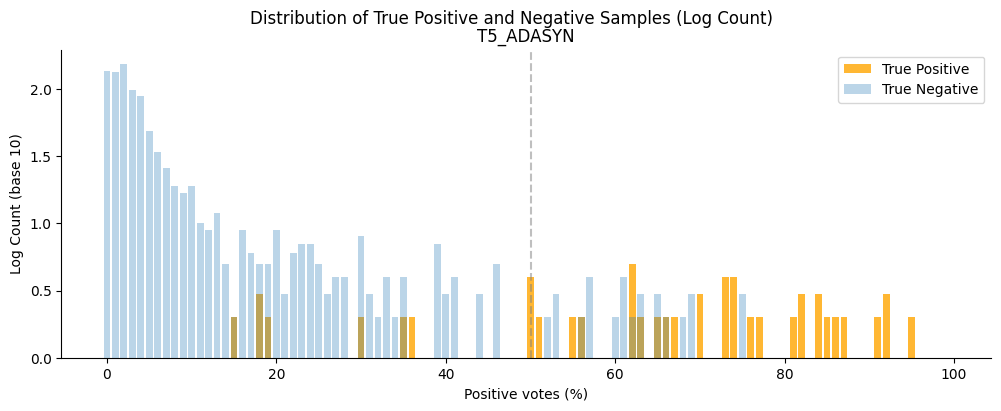

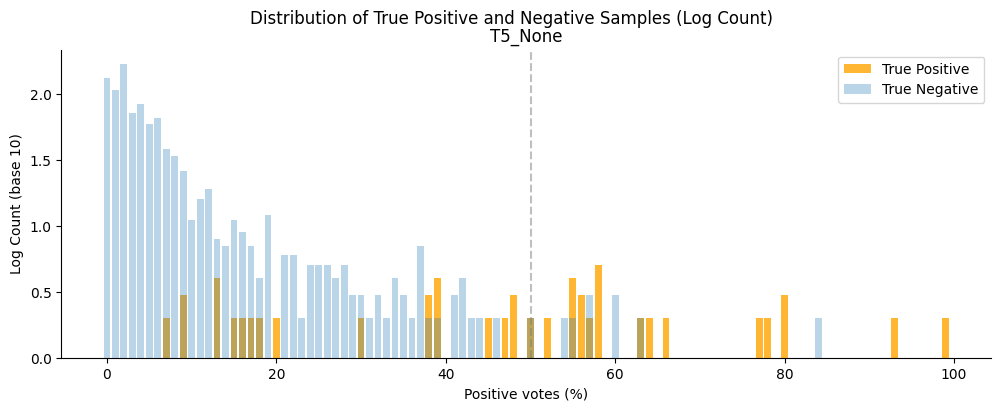

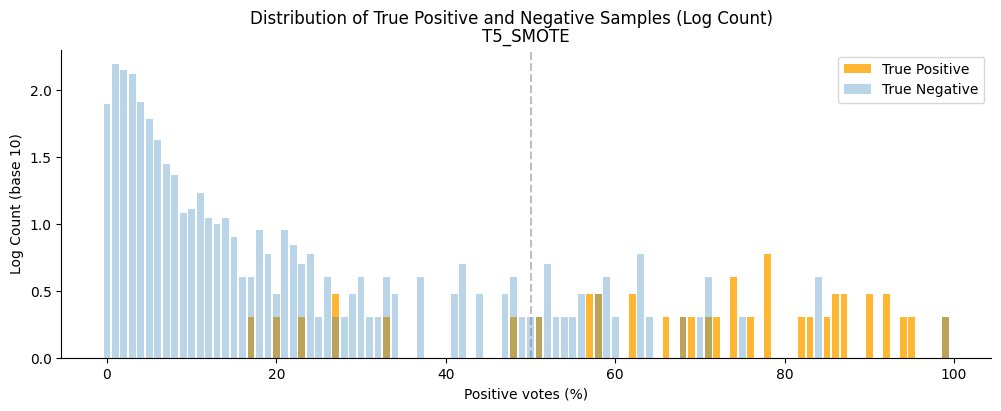

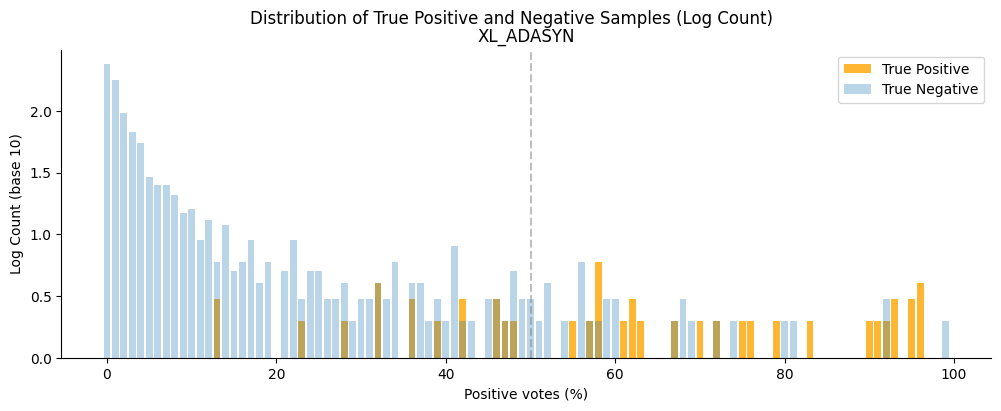

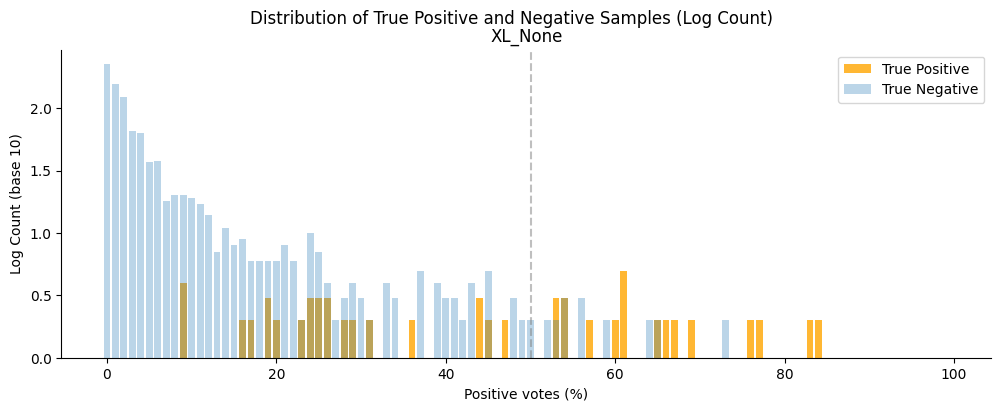

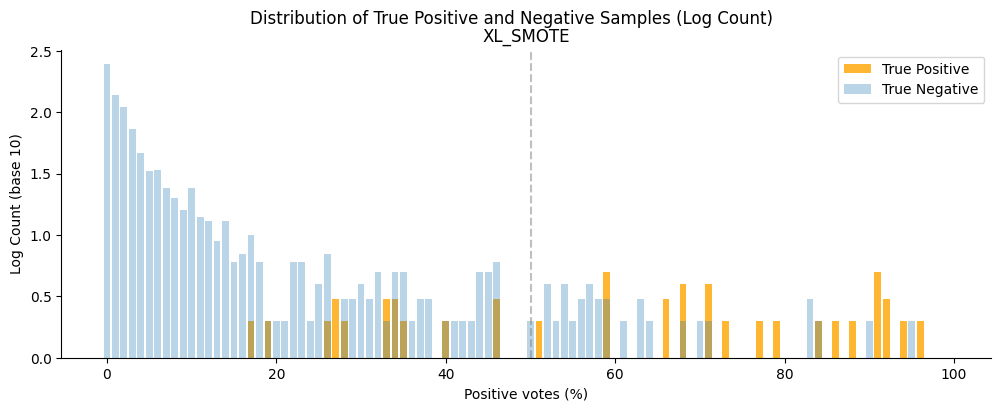

In [14]:
import math
for pipe in pipelines:
    # Get the true positive and negative samples for pipeline
    y_true = outer_folds[pipe]['y_true_all']
    y_proba = outer_folds[pipe]['y_proba_all']

    # Separate the true positive and negative samples
    true_positive = [y_proba[i] for i in range(len(y_true)) if y_true[i] == 1]
    true_negative = [y_proba[i] for i in range(len(y_true)) if y_true[i] == 0]

    # Calculate the log count for true positive and true negative samples
    log_true_positive = [math.log10(count) if count > 0 else 0 for count in np.histogram(true_positive, bins=100)[0]]
    log_true_negative = [math.log10(count) if count > 0 else 0 for count in np.histogram(true_negative, bins=100)[0]]

    # Plot the distribution
    plt.figure(figsize=(12, 4))  # Set the figsize to make the graph wider
    plt.bar(range(len(log_true_positive)), log_true_positive, alpha=0.8, label='True Positive', color='orange')
    plt.bar(range(len(log_true_negative)), log_true_negative, alpha=0.3, label='True Negative')
    plt.axvline(x=50, linestyle='--', color='gray', alpha=0.5)  # Add dashed vertical line at 50
    plt.xlabel('Positive votes (%)')
    plt.ylabel('Log Count (base 10)')
    plt.suptitle('Distribution of True Positive and Negative Samples (Log Count)')
    plt.title(pipe)
    plt.legend()

    # Remove upper and right border
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Save plot as png for report
    plt.savefig(os.path.join(PLOTS_DIR, f'distribution_{pipe}.png'), bbox_inches='tight')

    # Show the plot
    plt.show()


# K1
# Threshold of class 1 probability

In [15]:
def calculate_metrics(y_test, y_proba, threshold):
    # Convert probabilities to binary predictions based on threshold
    y_pred_binary = [1 if pred >= threshold else 0 for pred in y_proba]

    # Calculate true positives, false positives, true negatives, false negatives
    tp = sum([1 for i in range(len(y_test)) if y_test[i] == 1 and y_pred_binary[i] == 1])
    fp = sum([1 for i in range(len(y_test)) if y_test[i] == 0 and y_pred_binary[i] == 1])
    tn = sum([1 for i in range(len(y_test)) if y_test[i] == 0 and y_pred_binary[i] == 0])
    fn = sum([1 for i in range(len(y_test)) if y_test[i] == 1 and y_pred_binary[i] == 0])

    # Calculate precision, accuracy, recall, true positive rate, false positive rate
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

    return precision, accuracy, recall, f1


In [16]:
outer_folds['thresholds_1'] = np.linspace(0, 1, 101)

for pipe in pipelines:
    # First position corresponds to first threshold, second position corresponds to second threshold, etc.
    outer_folds[pipe]['precision_t'] = []
    outer_folds[pipe]['accuracy_t'] = []
    outer_folds[pipe]['recall_t'] = []
    outer_folds[pipe]['f1_t'] = []
    for t, threshold in enumerate(outer_folds['thresholds_1']):
        precision, accuracy, recall, f1 = calculate_metrics(outer_folds[pipe]['y_true_all'], outer_folds[pipe]['y_proba_all'], threshold)
        outer_folds[pipe]['precision_t'].append(precision)
        outer_folds[pipe]['accuracy_t'].append(accuracy)
        outer_folds[pipe]['recall_t'].append(recall)
        outer_folds[pipe]['f1_t'].append(f1)



The best threshold for T5_ADASYN is 0.48
The best F1 score for T5_ADASYN is 63.41463414634146
The best threshold for T5_None is 0.34
The best F1 score for T5_None is 62.882096069869
The best threshold for T5_SMOTE is 0.54
The best F1 score for T5_SMOTE is 60.0
The best threshold for XL_ADASYN is 0.29
The best F1 score for XL_ADASYN is 55.90062111801242
The best threshold for XL_None is 0.38
The best F1 score for XL_None is 55.81395348837209
The best threshold for XL_SMOTE is 0.58
The best F1 score for XL_SMOTE is 56.99999999999999


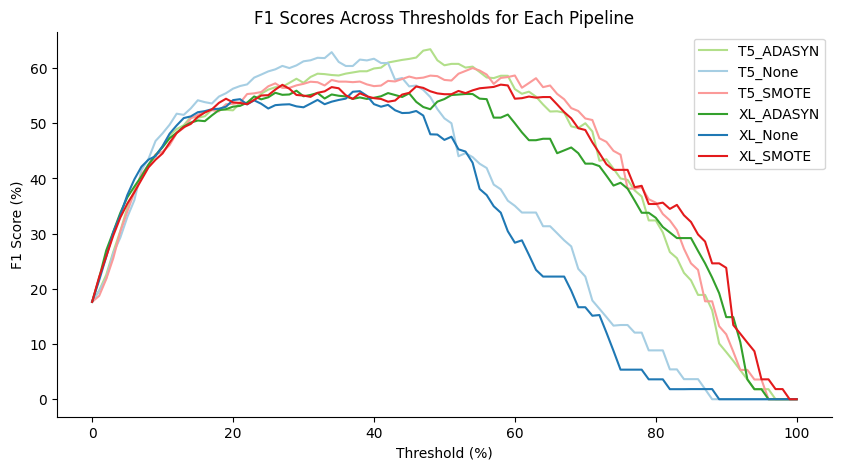

In [17]:
plt.figure(figsize=(10, 5))
for pipe in pipelines:
    f1_t = [score * 100 for score in outer_folds[pipe]['f1_t']]
    best_threshold_index = np.argmax(f1_t)
    best_threshold = outer_folds['thresholds_1'][best_threshold_index]
    print(f"The best threshold for {pipe} is {best_threshold}")
    print(f"The best F1 score for {pipe} is {f1_t[best_threshold_index]}")
    plt.plot(outer_folds['thresholds_1']*100, f1_t, color=colors_dict[pipe], label=pipe)

# Set labels and title
plt.xlabel('Threshold (%)')
plt.ylabel('F1 Score (%)')
plt.title('F1 Scores Across Thresholds for Each Pipeline')

# Show legend
plt.legend()

# Remove upper and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save plot as png for report
plt.savefig(os.path.join(PLOTS_DIR, 'f1_threshold_1.png'), bbox_inches='tight')

# Show the plot
plt.show()



Precision for T5 None: 0.00 Recall: 0.00
F1 score for T5 None: 0.00
Precision for T5 ADASYN: 0.00 Recall: 0.00
F1 score for T5 ADASYN: 0.00


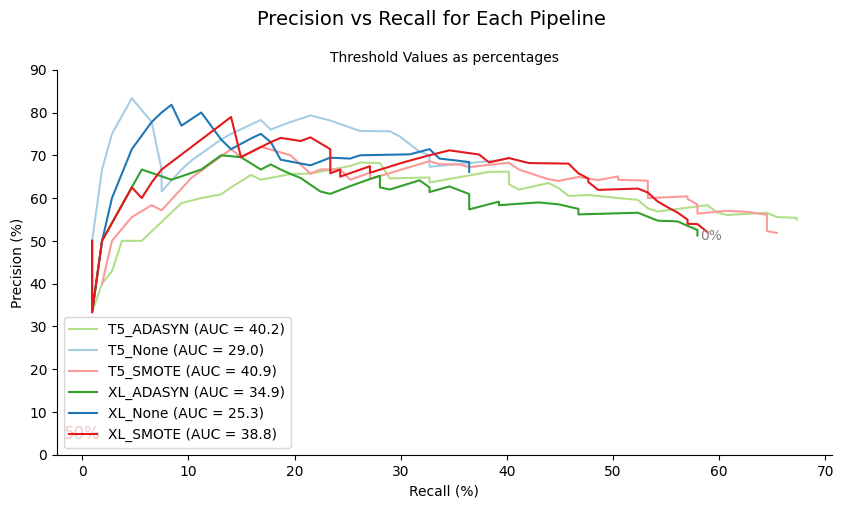

IndexError: list index out of range

In [23]:
from sklearn.metrics import auc
plt.figure(figsize=(10, 5))
auc_score = []
for pipe in pipelines:
    precision_t = outer_folds[pipe]['precision_t'].copy()
    recall_t = outer_folds[pipe]['recall_t'].copy()
    auc_value = auc(recall_t, precision_t) * 100
    auc_score.append(auc_value)

    # percentages
    precision_t = [score * 100 for score in precision_t]
    recall_t = [score * 100 for score in recall_t]

    precision_t = np.array(precision_t)
    recall_t = np.array(recall_t)

    non_zero_indices = np.nonzero(precision_t)

    plt.plot(recall_t[non_zero_indices], precision_t[non_zero_indices], color=colors_dict[pipe], label=f'{pipe} (AUC = {auc_value:.1f})')

    for i, threshold in enumerate(outer_folds['thresholds_1']):
        if pipe == 'XL_None':
            if threshold == 0.5:
                plt.annotate(f'{threshold*100:.0f}%', (recall_t[i], precision_t[i] + 5), fontsize=12, ha='center', va='center', color=colors_dict[pipe])
                print(f'Precision for T5 None: {precision_t[i]:.2f} Recall: {recall_t[i]:.2f}')
                print(f'F1 score for T5 None: {outer_folds[pipe]["f1_t"][i]:.2f}')
        elif pipe == 'XL_SMOTE':
            if threshold == 0.5:
                plt.annotate(f'{threshold*100:.0f}%', (recall_t[i], precision_t[i] + 5), fontsize=12, ha='center', va='center', color=colors_dict[pipe])
                print(f'Precision for T5 ADASYN: {precision_t[i]:.2f} Recall: {recall_t[i]:.2f}')
                print(f'F1 score for T5 ADASYN: {outer_folds[pipe]["f1_t"][i]:.2f}')
    if pipe == 'XL_SMOTE':
        for i, threshold in enumerate(outer_folds['thresholds_1']):
            if threshold == 0.:
                plt.annotate(f'{threshold*100:.0f}%', (recall_t[i+7] + 5, precision_t[i+7] - 8), fontsize=10, ha='center', va='center', color = 'gray')

# Set labels and title
plt.xlabel('Recall (%)')
plt.ylabel('Precision (%)')
plt.suptitle('Precision vs Recall for Each Pipeline', y=1, fontsize=14)
plt.title('Threshold Values as percentages', fontsize=10)
plt.ylim([0, 90])

# Move the legend to the lower left corner
plt.legend(loc='lower left')

# Remove upper and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save plot as png for report
plt.savefig(os.path.join(PLOTS_DIR, 'precision_recall_threshold.png'), bbox_inches='tight')

# Show the plot
plt.show()

# Print precision, recall, and f1 scores for T5 None and T5 ADASYN at threshold 0.8
for pipe in pipelines:
    if pipe == 'T5_None':
        print(f'Precision for T5 None: {outer_folds[pipe]["precision_t"][80]:.2f} Recall: {outer_folds[pipe]["recall_t"][80]:.2f}')
        print(f'F1 score for T5 None: {outer_folds[pipe]["f1_t"][80]:.2f}')
    elif pipe == 'T5_ADASYN':
        print(f'Precision for T5 ADASYN: {outer_folds[pipe]["precision_t"][80]:.2f} Recall: {outer_folds[pipe]["recall_t"][80]:.2f}')
        print(f'F1 score for T5 ADASYN: {outer_folds[pipe]["f1_t"][80]:.2f}')


In [19]:
plt.figure(figsize=(10, 5))
auc_score = []
for pipe in ['T5_None', 'T5_ADASYN']:
    precision_t = outer_folds[pipe]['precision_t'].copy()
    recall_t = outer_folds[pipe]['recall_t'].copy()
    auc_value = auc(recall_t, precision_t) * 100
    auc_score.append(auc_value)

    # percentages
    precision_t = [score * 100 for score in precision_t]
    recall_t = [score * 100 for score in recall_t]

    precision_t = np.array(precision_t)
    recall_t = np.array(recall_t)

    non_zero_indices = np.nonzero(precision_t)

    plt.plot(recall_t[non_zero_indices], precision_t[non_zero_indices], color=colors_dict[pipe], label=f'{pipe} (AUC = {auc_value:.1f})')

    for i, threshold in enumerate(outer_folds['thresholds_1']):
        if pipe == 'T5_None':
            if threshold == 0.34 or threshold == 0.8:
                plt.annotate(f'{threshold*100:.0f}%', (recall_t[i], precision_t[i] + 5), fontsize=12, ha='center', va='center', color=colors_dict[pipe])
                print(f'Precision for T5 None: {precision_t[i]:.2f} Recall: {recall_t[i]:.2f}')
                print(f'F1 score for T5 None: {outer_folds[pipe]["f1_t"][i]:.2f}')
        elif pipe == 'T5_ADASYN':
            if threshold == 0.48 or threshold == 0.8:
                plt.annotate(f'{threshold*100:.0f}%', (recall_t[i], precision_t[i] + 5), fontsize=12, ha='center', va='center', color=colors_dict[pipe])
                print(f'Precision for T5 ADASYN: {precision_t[i]:.2f} Recall: {recall_t[i]:.2f}')
                print(f'F1 score for T5 ADASYN: {outer_folds[pipe]["f1_t"][i]:.2f}')
    if pipe == 'XL_SMOTE':
        for i, threshold in enumerate(outer_folds['thresholds_1']):
            if threshold == 0.:
                plt.annotate(f'{threshold*100:.0f}%', (recall_t[i+7] + 5, precision_t[i+7] - 8), fontsize=10, ha='center', va='center', color = 'gray')

# Set labels and title
plt.xlabel('Recall (%)')
plt.ylabel('Precision (%)')
plt.suptitle('Precision vs Recall for Each Pipeline', y=1, fontsize=14)
plt.title('Threshold Values as percentages', fontsize=10)
plt.ylim([0, 90])

# Move the legend to the lower left corner
plt.legend(loc='lower left')

# Remove upper and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save plot as png for report
plt.savefig(os.path.join(PLOTS_DIR, 'precision_recall_threshold_sub.png'), bbox_inches='tight')

# Show the plot
plt.show()

# Print precision, recall, and f1 scores for T5 None and T5 ADASYN at threshold 0.8
for pipe in pipelines:
    if pipe == 'T5_None':
        print(f'Precision for T5 None: {outer_folds[pipe]["precision_t"][80]:.2f} Recall: {outer_folds[pipe]["recall_t"][80]:.2f}')
        print(f'F1 score for T5 None: {outer_folds[pipe]["f1_t"][80]:.2f}')
    elif pipe == 'T5_ADASYN':
        print(f'Precision for T5 ADASYN: {outer_folds[pipe]["precision_t"][80]:.2f} Recall: {outer_folds[pipe]["recall_t"][80]:.2f}')
        print(f'F1 score for T5 ADASYN: {outer_folds[pipe]["f1_t"][80]:.2f}')


NameError: name 'auc' is not defined

<Figure size 1000x500 with 0 Axes>

# K2
## Thresholds of class 1 - class 2 probability

In [20]:
def calculate_metrics(y_test, y_proba, threshold):
    # Convert probabilities to binary predictions based on threshold
    # y_pred_binary = [1 if pred >= threshold else 0 for pred in y_proba]

    y_pred_binary = [1 if (2 * pred - 1) >= threshold else 0 if (2 * pred - 1) <= threshold else 2 for pred in y_proba]

    # Calculate true positives, false positives, true negatives, false negatives
    tp = sum([1 for i in range(len(y_test)) if y_test[i] == 1 and y_pred_binary[i] == 1])
    fp = sum([1 for i in range(len(y_test)) if y_test[i] == 0 and y_pred_binary[i] == 1])
    tn = sum([1 for i in range(len(y_test)) if y_test[i] == 0 and y_pred_binary[i] == 0])
    fn = sum([1 for i in range(len(y_test)) if y_test[i] == 1 and y_pred_binary[i] == 0])

    # Calculate precision, accuracy, recall, true positive rate, false positive rate
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

    return precision, accuracy, recall, f1


In [21]:
# test calculate metrics on a short list
y_test = [1, 1, 1, 0, 0, 0]
y_proba = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
threshold = 0.9
precision, accuracy, recall, f1 = calculate_metrics(y_test, y_proba, threshold)
print(f'Precision: {precision:.2f} Accuracy: {accuracy:.2f} Recall: {recall:.2f} F1: {f1:.2f}')


Precision: 0.00 Accuracy: 0.50 Recall: 0.00 F1: 0.00


In [22]:
outer_folds['thresholds_2'] = np.linspace(0, 1, 51)

for pipe in pipelines:
    # First position corresponds to first threshold, second position corresponds to second threshold, etc.
    outer_folds[pipe]['precision_t'] = []
    outer_folds[pipe]['accuracy_t'] = []
    outer_folds[pipe]['recall_t'] = []
    outer_folds[pipe]['f1_t'] = []
    for t, threshold in enumerate(outer_folds['thresholds_2']):
        precision, accuracy, recall, f1 = calculate_metrics(outer_folds[pipe]['y_true_all'], outer_folds[pipe]['y_proba_all'], threshold)
        outer_folds[pipe]['precision_t'].append(precision)
        outer_folds[pipe]['accuracy_t'].append(accuracy)
        outer_folds[pipe]['recall_t'].append(recall)
        outer_folds[pipe]['f1_t'].append(f1)



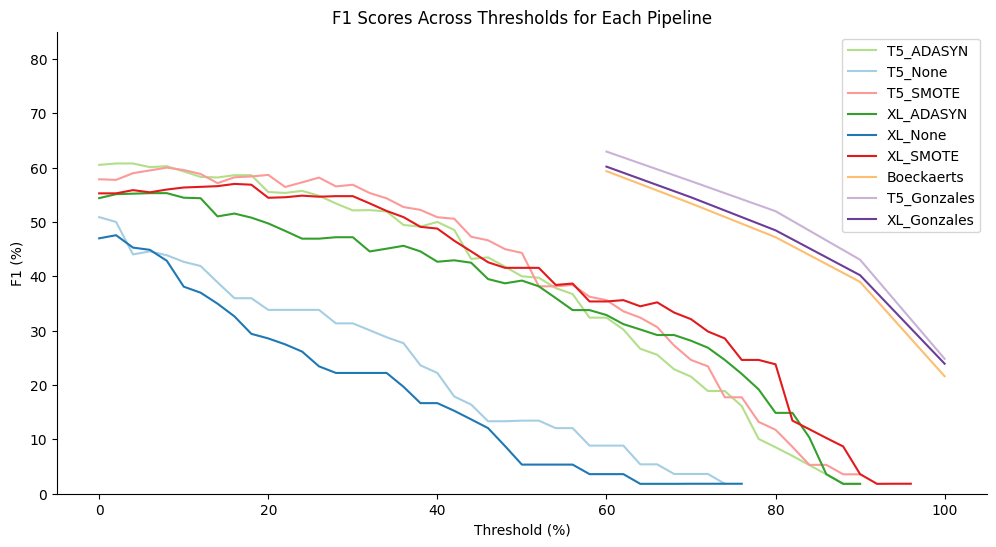

In [ ]:
references_f1 = dict()
references_f1['thresholds_2'] = np.linspace(0.6, 1, 5)
references_f1['Boeckaerts'] = [0.5935, 0.5341, 0.4720, 0.3897, 0.2161]
references_f1['T5_Gonzales'] = [0.6295, 0.5751, 0.5198, 0.4305, 0.2482]
references_f1['XL_Gonzales'] = [0.6018, 0.5454, 0.4846, 0.4020, 0.2392]

plt.figure(figsize=(12, 6))
for pipe in pipelines:
    f1_t = np.array(outer_folds[pipe]['f1_t'])
    non_zero_indices = np.where(f1_t != 0)
    plt.plot(outer_folds['thresholds_2'][non_zero_indices] * 100, f1_t[non_zero_indices] * 100, color=colors_dict[pipe], label=pipe)

for ref in ['Boeckaerts', 'T5_Gonzales', 'XL_Gonzales']:
    plt.plot(references_f1['thresholds_2'] * 100, np.array(references_f1[ref]) * 100, color=colors_dict[ref], label=ref)

# Set labels and title
plt.xlabel('Threshold (%)')
plt.ylabel('F1 (%)')
plt.title('F1 Scores Across Thresholds for Each Pipeline')
plt.ylim([0, 85])

# Show legend
plt.legend()

# Remove upper and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save plot as png for report
plt.savefig(os.path.join(PLOTS_DIR, 'f1_threshold_2.png'), bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
single_out_f1 = [0.5714285714285714, 0.6071428571428571, 0.5116279069767442, 0.6046511627906977, 0.7234042553191491]
mean_single_out_f1 = np.mean(single_out_f1) * 100
best_single_out_f1 = np.max(single_out_f1) * 100
std_single_out_f1 = np.std(single_out_f1)

print(f'Mean single out F1: {mean_single_out_f1:.2f}')
print(f'Best single out F1: {best_single_out_f1:.2f}')
print(f'Std single out F1: {std_single_out_f1:.2f}')

Mean single out F1: 60.37
Best single out F1: 72.34
Std single out F1: 0.07
